# Training-Aware Quantization of SpeechBrain Wav2Vec2 on GPU


This notebook provides code for training-aware quantization of the speechbrain/asr-wav2vec2-librispeech model. We compare fine-tuned base model and quantization-aware trained model on the librispeech dataset. Training is performed for two epochs.

First, we define the ASR class and write helper functions

In [1]:
import os
import sys
import torch
import logging
import speechbrain as sb
from speechbrain.utils.distributed import run_on_main, if_main_process
from hyperpyyaml import load_hyperpyyaml
from pathlib import Path

logger = logging.getLogger(__name__)


class ASR(sb.Brain):
    def compute_forward(self, batch, stage):
        """Forward computations from the waveform batches to the output probabilities."""
        batch = batch.to(self.device)
        wavs, wav_lens = batch.sig
        wavs, wav_lens = wavs.to(self.device), wav_lens.to(self.device)
        if hasattr(self.modules, "downsampler"):
            wavs = self.modules.downsampler(wavs)
        if stage == sb.Stage.TRAIN:
            if hasattr(self.modules, "env_corrupt"):
                wavs_noise = self.modules.env_corrupt(wavs, wav_lens)
                wavs = torch.cat([wavs, wavs_noise], dim=0)
                wav_lens = torch.cat([wav_lens, wav_lens])

            if hasattr(self.hparams, "augmentation"):
                wavs = self.hparams.augmentation(wavs, wav_lens)

        if hasattr(self.modules, "extractor"):
            latents = self.modules.extractor(wavs)
            feats = self.modules.encoder_wrapper(latents, wav_lens=wav_lens)[
                "embeddings"
            ]
        else:
            feats = self.modules.wav2vec2(wavs, wav_lens)

        x = self.modules.enc(feats)

        p_tokens = None
        logits = self.modules.ctc_lin(x)

        if hasattr(self.hparams, "upsampling") and self.hparams.upsampling:
            logits = logits.view(
                logits.shape[0], -1, self.hparams.output_neurons
            )

        p_ctc = self.hparams.log_softmax(logits)
        if stage == sb.Stage.VALID or (
            stage == sb.Stage.TEST and not self.hparams.use_language_modelling
        ):

            p_tokens = sb.decoders.ctc_greedy_decode(
                p_ctc, wav_lens, blank_id=self.hparams.blank_index
            )
        return p_ctc, wav_lens, p_tokens

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss (CTC+NLL) given predictions and targets."""

        p_ctc, wav_lens, predicted_tokens = predictions

        ids = batch.id
        tokens, tokens_lens = batch.tokens

        if hasattr(self.modules, "env_corrupt") and stage == sb.Stage.TRAIN:
            tokens = torch.cat([tokens, tokens], dim=0)
            tokens_lens = torch.cat([tokens_lens, tokens_lens], dim=0)

        loss_ctc = self.hparams.ctc_cost(p_ctc, tokens, wav_lens, tokens_lens)
        loss = loss_ctc

        if stage == sb.Stage.VALID:
            predicted_words = [
                "".join(self.tokenizer.decode_ndim(utt_seq)).split(" ")
                for utt_seq in predicted_tokens
            ]
            target_words = [wrd.split(" ") for wrd in batch.wrd]
            self.wer_metric.append(ids, predicted_words, target_words)
            self.cer_metric.append(ids, predicted_words, target_words)
        if stage == sb.Stage.TEST:
            if self.hparams.use_language_modelling:
                predicted_words = []
                for logs in p_ctc:
                    text = decoder.decode(logs.detach().cpu().numpy())
                    predicted_words.append(text.split(" "))
            else:
                predicted_words = [
                    "".join(self.tokenizer.decode_ndim(utt_seq)).split(" ")
                    for utt_seq in predicted_tokens
                ]
            target_words = [wrd.split(" ") for wrd in batch.wrd]
            self.wer_metric.append(ids, predicted_words, target_words)
            self.cer_metric.append(ids, predicted_words, target_words)
        return loss

    def fit_batch(self, batch):
        should_step = self.step % self.grad_accumulation_factor == 0

        if self.auto_mix_prec:
            self.wav2vec_optimizer.zero_grad()
            self.model_optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                with self.no_sync():
                    outputs = self.compute_forward(batch, sb.Stage.TRAIN)
                loss = self.compute_objectives(outputs, batch, sb.Stage.TRAIN)
            with self.no_sync(not should_step):
                self.scaler.scale(
                    loss / self.grad_accumulation_factor
                ).backward()
            if should_step:
                if not self.hparams.freeze_wav2vec:
                    self.scaler.unscale_(self.wav2vec_optimizer)
                self.scaler.unscale_(self.model_optimizer)
                if self.check_gradients(loss):
                    self.scaler.step(self.wav2vec_optimizer)
                    self.scaler.step(self.model_optimizer)
                self.scaler.update()
                self.optimizer_step += 1
        else:
            with self.no_sync():
                outputs = self.compute_forward(batch, sb.Stage.TRAIN)
            loss = self.compute_objectives(outputs, batch, sb.Stage.TRAIN)
            (loss / self.grad_accumulation_factor).backward()
            if should_step:
                if self.check_gradients(loss):
                    self.wav2vec_optimizer.step()
                    self.model_optimizer.step()
                self.wav2vec_optimizer.zero_grad()
                self.model_optimizer.zero_grad()
                self.optimizer_step += 1

        return loss.detach().cpu()

    def on_stage_start(self, stage, epoch):
        """Gets called at the beginning of each epoch"""
        if stage != sb.Stage.TRAIN:
            self.cer_metric = self.hparams.cer_computer()
            self.wer_metric = self.hparams.error_rate_computer()

    def on_stage_end(self, stage, stage_loss, epoch):
        """Gets called at the end of an epoch."""
        stage_stats = {"loss": stage_loss}
        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats
        else:
            stage_stats["CER"] = self.cer_metric.summarize("error_rate")
            stage_stats["WER"] = self.wer_metric.summarize("error_rate")

        if stage == sb.Stage.VALID:
            old_lr_model, new_lr_model = self.hparams.lr_annealing_model(
                stage_stats["loss"]
            )
            old_lr_wav2vec, new_lr_wav2vec = self.hparams.lr_annealing_wav2vec(
                stage_stats["loss"]
            )
            sb.nnet.schedulers.update_learning_rate(
                self.model_optimizer, new_lr_model
            )
            sb.nnet.schedulers.update_learning_rate(
                self.wav2vec_optimizer, new_lr_wav2vec
            )
            self.hparams.train_logger.log_stats(
                stats_meta={
                    "epoch": epoch,
                    "lr_model": old_lr_model,
                    "lr_wav2vec": old_lr_wav2vec,
                },
                train_stats=self.train_stats,
                valid_stats=stage_stats,
            )
            self.checkpointer.save_and_keep_only(
                meta={"WER": stage_stats["WER"]}, min_keys=["WER"],
            )
        elif stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                stats_meta={"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stage_stats,
            )
            if if_main_process():
                with open(self.hparams.test_wer_file, "w") as w:
                    self.wer_metric.write_stats(w)

    def init_optimizers(self):
        "Initializes the wav2vec2 optimizer and model optimizer"
        if hasattr(self.modules, "extractor"):
            self.wav2vec_optimizer = self.hparams.wav2vec_opt_class(
                self.modules.encoder_wrapper.parameters()
            )

        else:
            self.wav2vec_optimizer = self.hparams.wav2vec_opt_class(
                self.modules.wav2vec2.parameters()
            )

        self.model_optimizer = self.hparams.model_opt_class(
            self.hparams.model.parameters()
        )

        if self.checkpointer is not None:
            self.checkpointer.add_recoverable(
                "wav2vec_opt", self.wav2vec_optimizer
            )
            self.checkpointer.add_recoverable("modelopt", self.model_optimizer)

    def zero_grad(self, set_to_none=False):
        self.wav2vec_optimizer.zero_grad(set_to_none)
        self.model_optimizer.zero_grad(set_to_none)


def dataio_prepare(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions."""
    data_folder = hparams["data_folder"]

    train_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["train_csv"], replacements={"data_root": data_folder},
    )

    if hparams["sorting"] == "ascending":
        train_data = train_data.filtered_sorted(sort_key="duration")
        hparams["train_dataloader_opts"]["shuffle"] = False

    elif hparams["sorting"] == "descending":
        train_data = train_data.filtered_sorted(
            sort_key="duration", reverse=True
        )

        hparams["train_dataloader_opts"]["shuffle"] = False

    elif hparams["sorting"] == "random":
        pass

    else:
        raise NotImplementedError(
            "sorting must be random, ascending or descending"
        )

    valid_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["valid_csv"], replacements={"data_root": data_folder},
    )
    valid_data = valid_data.filtered_sorted(sort_key="duration")

    test_datasets = {}
    for csv_file in hparams["test_csv"]:
        name = Path(csv_file).stem
        test_datasets[name] = sb.dataio.dataset.DynamicItemDataset.from_csv(
            csv_path=csv_file, replacements={"data_root": data_folder}
        )
        test_datasets[name] = test_datasets[name].filtered_sorted(
            sort_key="duration"
        )

    datasets = [train_data, valid_data] + [i for k, i in test_datasets.items()]

    @sb.utils.data_pipeline.takes("wav")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav):
        sig = sb.dataio.dataio.read_audio(wav)
        return sig

    sb.dataio.dataset.add_dynamic_item(datasets, audio_pipeline)
    label_encoder = sb.dataio.encoder.CTCTextEncoder()

    @sb.utils.data_pipeline.takes("wrd")
    @sb.utils.data_pipeline.provides(
        "wrd", "char_list", "tokens_list", "tokens"
    )
    def text_pipeline(wrd):
        yield wrd
        char_list = list(wrd)
        yield char_list
        tokens_list = label_encoder.encode_sequence(char_list)
        yield tokens_list
        tokens = torch.LongTensor(tokens_list)
        yield tokens

    sb.dataio.dataset.add_dynamic_item(datasets, text_pipeline)

    lab_enc_file = os.path.join(hparams["save_folder"], "label_encoder.txt")
    special_labels = {
        "blank_label": hparams["blank_index"],
    }
    label_encoder.load_or_create(
        path=lab_enc_file,
        from_didatasets=[train_data],
        output_key="char_list",
        special_labels=special_labels,
        sequence_input=True,
    )

    sb.dataio.dataset.set_output_keys(
        datasets, ["id", "sig", "wrd", "char_list", "tokens"],
    )

    return train_data, valid_data, test_datasets, label_encoder



## Prepare Data

In [2]:
from datasets import load_dataset, load_metric

data = load_dataset("/home/kmb85/SpeechBrainQuant/LibriSpeech")

Resolving data files:   0%|          | 0/585 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/87 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/97 [00:00<?, ?it/s]

Using custom data configuration LibriSpeech-49d9aec4ade7f44e
Reusing dataset text (/home/kmb85/.cache/huggingface/datasets/text/LibriSpeech-49d9aec4ade7f44e/0.0.0/08f6fb1dd2dab0a18ea441c359e1d63794ea8cb53e7863e6edf8fc5655e47ec4)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
from parse_data import parse_to_json
import json
import os

parse_to_json("./LibriSpeech/dev-clean")
os.rename('data.json', 'dev-clean.json')
with open('/home/kmb85/SpeechBrainQuant/dev-clean.json', 'r') as file:
    dev_clean_data = json.load(file)

parse_to_json("./LibriSpeech/test-clean")
os.rename('data.json', 'test-clean.json')
with open('/home/kmb85/SpeechBrainQuant/test-clean.json', 'r') as file:
    test_clean_data = json.load(file)

In [4]:
dev_clean_dict = {}
for key, value in dev_clean_data.items():
    new_key = key.replace('-', '')
    dev_clean_dict[new_key] = value

In [5]:
test_clean_dict = {}
for key, value in test_clean_data.items():
    new_key = key.replace('-', '')
    test_clean_dict[new_key] = value

In [6]:
import soundfile as sf
import resampy

def flac_to_array_with_sampling_rate(file_path, target_sr=16000):
    data, sr = sf.read(file_path, dtype='float32')

    if sr != target_sr:
        data = resampy.resample(data, sr, target_sr)

    return data

In [7]:
import re
chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"]'

def remove_special_characters_dev(batch):
    batch["text"] = re.sub(chars_to_ignore_regex, '', batch["text"]).lower() + " "
    trimmed_string = batch["text"].strip()
    words = trimmed_string.split()
    new_text = ' '.join(words[1:])
    batch["text"] = new_text
    batch["input_values"] = flac_to_array_with_sampling_rate(dev_clean_dict[words[0]]['file_path'])
    return batch

In [ ]:
data['validation'] = data['validation'].map(remove_special_characters_dev)

In [9]:
import re
chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"]'

def remove_special_characters_test(batch):
    batch["text"] = re.sub(chars_to_ignore_regex, '', batch["text"]).lower() + " "
    trimmed_string = batch["text"].strip()
    words = trimmed_string.split()
    new_text = ' '.join(words[1:])
    batch["text"] = new_text
    batch["input_values"] = flac_to_array_with_sampling_rate(test_clean_dict[words[0]]['file_path'])
    return batch

In [ ]:
data['test'] = data['test'].map(remove_special_characters_test)

## Base Model Traing

In [11]:
hparams_file = 'hparams/train_hf_wav2vec_base.yaml'
run_opts = {"device":"cuda"}

In [ ]:
sb.utils.distributed.ddp_init_group(run_opts)

with open(hparams_file) as fin:
    hparams = load_hyperpyyaml(fin, '')

sb.create_experiment_directory(
    experiment_directory=hparams["output_folder"],
    hyperparams_to_save=hparams_file,
    overrides='',
)

In [ ]:
from librispeech_prepare import prepare_librispeech

run_on_main(
    prepare_librispeech,
    kwargs={
        "data_folder": hparams["data_folder"],
        "tr_splits": hparams["train_splits"],
        "dev_splits": hparams["dev_splits"],
        "te_splits": hparams["test_splits"],
        "save_folder": hparams["output_folder"],
        "merge_lst": hparams["train_splits"],
        "merge_name": "train.csv",
        "skip_prep": hparams["skip_prep"],
    },
)

In [14]:
train_data, valid_data, test_datasets, label_encoder = dataio_prepare(
    hparams
)

if hasattr(hparams, "use_language_modelling"):
    if hparams["use_language_modelling"]:
        try:
            from pyctcdecode import build_ctcdecoder
        except ImportError:
            err_msg = "Optional dependencies must be installed to use pyctcdecode.\n"
            err_msg += "Install using `pip install kenlm pyctcdecode`.\n"
            raise ImportError(err_msg)

        ind2lab = label_encoder.ind2lab
        labels = [ind2lab[x] for x in range(len(ind2lab))]
        labels = [""] + labels[
            1:
        ]
        decoder = build_ctcdecoder(
            labels,
            kenlm_model_path=hparams["ngram_lm_path"],  # .arpa or .bin
            alpha=0.5,  # Default by KenLM
            beta=1.0,  # Default by KenLM
        )
else:
    hparams["use_language_modelling"] = False

speechbrain.dataio.encoder - Moving label 'T' from index 0, because '<blank>' was put at its place.
speechbrain.dataio.encoder - Load called, but CTCTextEncoder is not empty. Loaded data will overwrite everything. This is normal if there is e.g. an unk label defined at init.


In [15]:
asr_brain_base = ASR(
    modules=hparams["modules"],
    hparams=hparams,
    run_opts=run_opts,
    checkpointer=hparams["checkpointer"],
)

if "pretrainer" in hparams.keys():
    run_on_main(hparams["pretrainer"].collect_files)
    hparams["pretrainer"].load_collected('cuda')

asr_brain_base.tokenizer = label_encoder

speechbrain.core - Info: auto_mix_prec arg from hparam file is used
speechbrain.core - Info: ckpt_interval_minutes arg from hparam file is used
speechbrain.core - 2.1M trainable parameters in ASR


In [ ]:
asr_brain_base.fit(
    asr_brain_base.hparams.epoch_counter,
    train_data,
    valid_data,
    train_loader_kwargs=hparams["train_dataloader_opts"],
    valid_loader_kwargs=hparams["valid_dataloader_opts"],
)

In [ ]:
# Testing
if not os.path.exists(hparams["output_wer_folder"]):
    os.makedirs(hparams["output_wer_folder"])

for k in test_datasets.keys():
    asr_brain_base.hparams.test_wer_file = os.path.join(
        hparams["output_wer_folder"], f"wer_{k}.txt"
    )
    asr_brain_base.evaluate(
        test_datasets[k],
        test_loader_kwargs=hparams["test_dataloader_opts"],
        min_key="WER",
    )

In [ ]:
torch.onnx.export(asr_brain_base.modules.wav2vec2.model,
     torch.tensor(data['validation'][:1]['input_values']).cuda(),
     f="asr-wav2vec2-librispeech-finetuned-base.onnx",
     export_params=True,
     opset_version=17,
     do_constant_folding=True,
     input_names = ['modelInput'],
     output_names = ['modelOutput'],
     dynamic_axes={'modelInput' : {0 : 'batch_size', 1: 'batch_size'},
     'modelOutput' : {0 : 'batch_size'}}
)

## Quantization-Aware Training

In [11]:
hparams_file = 'hparams/train_hf_wav2vec_quantized.yaml'
run_opts = {"device":"cuda"}

In [12]:
sb.utils.distributed.ddp_init_group(run_opts)

with open(hparams_file) as fin:
    hparams = load_hyperpyyaml(fin, '')

sb.create_experiment_directory(
    experiment_directory=hparams["output_folder"],
    hyperparams_to_save=hparams_file,
    overrides='',
)

Downloading:   0%|          | 0.00/158 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.18G [00:00<?, ?B/s]

/home/kmb85/.local/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
Some weights of the model checkpoint at facebook/wav2vec2-large-960h-lv60-self were not used when initializing Wav2Vec2Model: ['lm_head.weight', 'lm_head.bias']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2Model were not initialized from the model ch

speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/train_wav2vec2_char/1987


In [ ]:
from librispeech_prepare import prepare_librispeech

run_on_main(
    prepare_librispeech,
    kwargs={
        "data_folder": hparams["data_folder"],
        "tr_splits": hparams["train_splits"],
        "dev_splits": hparams["dev_splits"],
        "te_splits": hparams["test_splits"],
        "save_folder": hparams["output_folder"],
        "merge_lst": hparams["train_splits"],
        "merge_name": "train.csv",
        "skip_prep": hparams["skip_prep"],
    },
)

In [14]:
train_data, valid_data, test_datasets, label_encoder = dataio_prepare(
    hparams
)

if hasattr(hparams, "use_language_modelling"):
    if hparams["use_language_modelling"]:
        try:
            from pyctcdecode import build_ctcdecoder
        except ImportError:
            err_msg = "Optional dependencies must be installed to use pyctcdecode.\n"
            err_msg += "Install using `pip install kenlm pyctcdecode`.\n"
            raise ImportError(err_msg)

        ind2lab = label_encoder.ind2lab
        labels = [ind2lab[x] for x in range(len(ind2lab))]
        labels = [""] + labels[
            1:
        ]
        decoder = build_ctcdecoder(
            labels,
            kenlm_model_path=hparams["ngram_lm_path"],  # .arpa or .bin
            alpha=0.5,  # Default by KenLM
            beta=1.0,  # Default by KenLM
        )
else:
    hparams["use_language_modelling"] = False

speechbrain.dataio.encoder - Load called, but CTCTextEncoder is not empty. Loaded data will overwrite everything. This is normal if there is e.g. an unk label defined at init.


In [15]:
asr_brain_quantized = ASR(
    modules=hparams["modules"],
    hparams=hparams,
    run_opts=run_opts,
    checkpointer=hparams["checkpointer"],
)

if "pretrainer" in hparams.keys():
    run_on_main(hparams["pretrainer"].collect_files)
    hparams["pretrainer"].load_collected('cuda')

asr_brain_quantized.tokenizer = label_encoder

speechbrain.core - Info: auto_mix_prec arg from hparam file is used
speechbrain.core - Info: ckpt_interval_minutes arg from hparam file is used
speechbrain.core - 2.1M trainable parameters in ASR


In [24]:
import tensorrt

In [25]:
import os
os.environ['TRANSFORMERS_CACHE'] = '/home/kmb85/rds/hpc-work/huggingface'
os.environ['HF_HOME']='/home/kmb85/rds/hpc-work/huggingface'

In [26]:
from pytorch_quantization import nn as quant_nn
from pytorch_quantization import quant_modules
from pytorch_quantization.tensor_quant import QuantDescriptor
from pytorch_quantization import calib

In [27]:
quant_desc_input = QuantDescriptor(calib_method='max', num_bits=8, fake_quant=True)
quant_nn.QuantConv1d.set_default_quant_desc_input(quant_desc_input)
quant_nn.QuantLinear.set_default_quant_desc_input(quant_desc_input)

In [29]:
from speechbrain.pretrained import EncoderASR

quant_modules.initialize()
model_full_quantized = EncoderASR.from_hparams(source="speechbrain/asr-wav2vec2-librispeech", run_opts={"device":"cuda"})

hyperparams.yaml:   0%|          | 0.00/1.78k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.18G [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/wav2vec2-large-960h-lv60-self were not used when initializing Wav2Vec2Model: ['lm_head.weight', 'lm_head.bias']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-large-960h-lv60-self and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


speechbrain.lobes.models.huggingface_wav2vec - speechbrain.lobes.models.huggingface_wav2vec - wav2vec 2.0 is frozen.


W0108 14:06:04.263104 140341998555136 huggingface_wav2vec.py:146] speechbrain.lobes.models.huggingface_wav2vec - wav2vec 2.0 is frozen.


wav2vec2.ckpt:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

asr.ckpt:   0%|          | 0.00/8.53M [00:00<?, ?B/s]

tokenizer.ckpt:   0%|          | 0.00/426 [00:00<?, ?B/s]

In [30]:
model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv._weight_quantizer.enable_calib()
model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv._weight_quantizer.disable_quant()

In [31]:
model_full_quantized = model_full_quantized.to('cuda')

In [33]:
import torch
with torch.no_grad():
    for i in range(2000):
            input_value = torch.tensor(data["validation"][i:i+1]["input_values"], device="cuda")
            _ = model_full_quantized.mods.encoder.wav2vec2.model(input_value)

In [34]:
# Finalize calibration

model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv._weight_quantizer.load_calib_amax()
model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv._weight_quantizer.disable_calib()
model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv._weight_quantizer.enable_quant()

model_full_quantized.cuda()

absl - Load calibrated amax, shape=torch.Size([512, 1, 1]).


W0108 14:13:53.678715 140341998555136 tensor_quantizer.py:238] Load calibrated amax, shape=torch.Size([512, 1, 1]).


absl - Call .cuda() if running on GPU after loading calibrated amax.


W0108 14:13:53.681514 140341998555136 tensor_quantizer.py:239] Call .cuda() if running on GPU after loading calibrated amax.


absl - Disable MaxCalibrator


W0108 14:13:53.682647 140341998555136 tensor_quantizer.py:174] Disable MaxCalibrator


EncoderASR(
  (mods): ModuleDict(
    (encoder): LengthsCapableSequential(
      (wav2vec2): HuggingFaceWav2Vec2(
        (model): Wav2Vec2Model(
          (feature_extractor): Wav2Vec2FeatureEncoder(
            (conv_layers): ModuleList(
              (0): Wav2Vec2LayerNormConvLayer(
                (conv): QuantConv1d(
                  1, 512, kernel_size=(10,), stride=(5,)
                  (_input_quantizer): TensorQuantizer(8bit fake per-tensor amax=dynamic calibrator=MaxCalibrator scale=1.0 quant)
                  (_weight_quantizer): TensorQuantizer(8bit fake axis=0 amax=[0.0071, 0.6079](512) calibrator=MaxCalibrator scale=1.0 quant)
                )
                (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
                (activation): GELUActivation()
              )
              (1-4): 4 x Wav2Vec2LayerNormConvLayer(
                (conv): QuantConv1d(
                  512, 512, kernel_size=(3,), stride=(2,)
                  (_input_quantizer

In [35]:
asr_brain_quantized.modules.wav2vec2.model.feature_extractor.conv_layers[0].conv = model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv

In [ ]:
asr_brain_quantized.fit(
    asr_brain_quantized.hparams.epoch_counter,
    train_data,
    valid_data,
    train_loader_kwargs=hparams["train_dataloader_opts"],
    valid_loader_kwargs=hparams["valid_dataloader_opts"],
)

In [1]:
# Testing
if not os.path.exists(hparams["output_wer_folder"]):
    os.makedirs(hparams["output_wer_folder"])

for k in test_datasets.keys():
    asr_brain_quantized.hparams.test_wer_file = os.path.join(
        hparams["output_wer_folder"], f"wer_{k}.txt"
    )
    asr_brain_quantized.evaluate(
        test_datasets[k],
        test_loader_kwargs=hparams["test_dataloader_opts"],
        min_key="WER",
    )

speechbrain.utils.train_logger - Epoch loaded: 2 - test loss: 4.83e-02, test CER: 6.08e-01, test WER: 3.64


In [39]:
torch.onnx.export(asr_brain_quantized.modules.wav2vec2.model,
     torch.tensor(data['validation'][:1]['input_values']).cuda(),
     f="asr-wav2vec2-librispeech-qat.onnx",
     export_params=True,
     opset_version=17,
     do_constant_folding=True,
     input_names = ['modelInput'],
     output_names = ['modelOutput'],
     dynamic_axes={'modelInput' : {0 : 'batch_size', 1: 'batch_size'},
     'modelOutput' : {0 : 'batch_size'}}
)

/home/kmb85/.local/lib/python3.10/site-packages/pytorch_quantization/tensor_quant.py:257: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if amax.numel() == 1:
/home/kmb85/.local/lib/python3.10/site-packages/pytorch_quantization/tensor_quant.py:260: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  axis = amax.shape.index(amax.numel())


## Base vs Quantized Model Accuracy

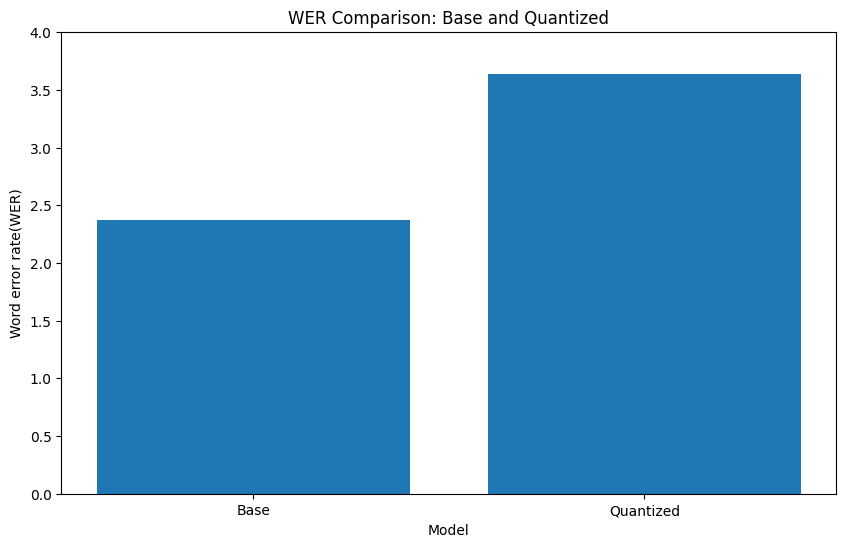

In [2]:
import matplotlib.pyplot as plt

models = ['Base', 'Quantized']
inference_times = [2.37, 3.64]

plt.figure(figsize=(10, 6))
plt.bar(models, inference_times)
plt.xlabel('Model')
plt.ylabel('Word error rate(WER)')
plt.title('WER Comparison: Base and Quantized')
plt.ylim(0, max(inference_times) * 1.1)
plt.show()

In [5]:
percentage_diff = ((3.64 - 2.37) / 3.64) * 100
print(f'WER difference between the quantized model and the base model is {round(percentage_diff, 2)}%')

WER difference between the quantized model and the base model is 34.89%


## Base vs Quantized Model Inference Time

In [21]:
import onnxruntime as ort
ort.get_device()

'GPU'

In [ ]:
ort_sess_base = ort.InferenceSession('asr-wav2vec2-librispeech-finetuned-base.onnx')
ort_sess_quantized = ort.InferenceSession('asr-wav2vec2-librispeech-qat.onnx', providers=['TensorrtExecutionProvider'])


In [27]:
import time
import numpy

def compute_inference_time(ort_sess, num_samples):
    model_time = 0
    with torch.no_grad():
        for single_batch in data["test"].select(range(num_samples)):
            input_values = torch.tensor(single_batch["input_values"], device="cpu").unsqueeze(0)
            input_values = input_values.clone().detach().numpy().astype(numpy.float32)
            starttime = time.time()
            ort_sess.run(['modelOutput'], {'modelInput': input_values})
            model_time += time.time() - starttime
    return round(model_time/num_samples, 8)

In [28]:
num_samples = 50

base_model_time = compute_inference_time(ort_sess_base, num_samples)

In [29]:
print(f'Base Fine-Tuned Model inference time {base_model_time} seconds')

Base Fine-Tuned Model inference time 0.45936726 seconds


In [33]:
quantized_model_time = compute_inference_time(ort_sess_quantized, num_samples)

In [34]:
print(f'Quantization Aware Trained Model inference time {quantized_model_time} seconds')

Quantization Aware Trained Model inference time 0.02008545 seconds


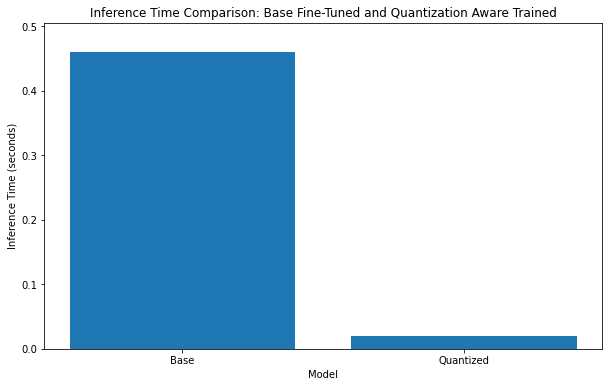

In [35]:
import matplotlib.pyplot as plt

models = ['Base', 'Quantized']
inference_times = [base_model_time, quantized_model_time]

plt.figure(figsize=(10, 6))
plt.bar(models, inference_times)
plt.xlabel('Model')
plt.ylabel('Inference Time (seconds)')
plt.title('Inference Time Comparison: Base Fine-Tuned and Quantization Aware Trained')
plt.ylim(0, max(inference_times) * 1.1)
plt.show()